# Задание 4
Свой проект по обработке текстов
(обнаружение трендов в использовании терминов, отбор статей по предметной области для обзора или их фрагментов, выделение ссылок на интересные вам работы по их описанию, ...).

# Отбор терминов по годам
Для начала необходимо распределить научные статьи по годам и отобрать термины (будем использовать метрику weirdness)

In [126]:
from tqdm import tqdm
import re
import csv
import os
import zipfile
import shutil
import pandas as pd
import numpy as np

In [8]:
# Читаем статьи из файла
articles_file = open('/content/pdf_output_all.txt', 'r')
articles = articles_file.read().split('='*30)

In [48]:
# Создаем словарь для группировки статей по годам
years_articles = {}

# Группируем
for a in articles:
    art_year = re.findall('20\d\d', a[:300])
    try:
      if art_year[0] not in years_articles:
          years_articles[art_year[0]] = []
    except IndexError:
        continue
    years_articles[art_year[0]].append(a)

In [ ]:
!pip install pymorphy3

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pymorphy3
import numpy as np

morph = pymorphy3.MorphAnalyzer()

In [18]:
# Функция нормализации
def normalizePymorphy(text):
    tokens = re.findall('[а-яёА-ЯЁ]+-[а-яёА-ЯЁ]+-[а-яёА-ЯЁ]+|[а-яёА-ЯЁ]+-[а-яёА-ЯЁ]+|[а-яёА-ЯЁ]+', text)
    words = []
    for t in tokens:
        pv = morph.parse(t)
        if str(pv[0].tag.POS) in ['ADJF', 'ADJS', 'NOUN', 'VERB', 'PRTF', 'PRTS', 'GRND', 'PREP']:
            words.append(pv[0].normal_form)
    return words

## Сбор контрастивной коллекции

 Для рассчета **weirdness**, необходимо собрать констрастивную коллекцию. Возьмём статьи с того же журнала, но по медицинской тематике.

In [21]:
# Читаем статьи из файла
med_articles_file = open('/content/med_pdf_output.txt', 'r')
med_articles = med_articles_file.read().split('='*30)

In [22]:
med_articles_norm = [' '.join(normalizePymorphy(med_a)) for med_a in tqdm(med_articles)]

100%|██████████| 642/642 [04:45<00:00,  2.25it/s]


In [23]:
med_tfv1 = CountVectorizer(token_pattern="[а-яёА-ЯЁ]+-[а-яёА-ЯЁ]+-[а-яёА-ЯЁ]+|[а-яёА-ЯЁ]+-[а-яёА-ЯЁ]+|[а-яёА-ЯЁ]+",
                      ngram_range=(1, 1)) #только униграммы
med_tfv2 = CountVectorizer(token_pattern="[а-яёА-ЯЁ]+-[а-яёА-ЯЁ]+-[а-яёА-ЯЁ]+|[а-яёА-ЯЁ]+-[а-яёА-ЯЁ]+|[а-яёА-ЯЁ]+",
                      ngram_range=(2, 2)) #только биграммы

In [24]:
med_tf1_articles = med_tfv1.fit_transform(tqdm(med_articles_norm))
med_tf2_articles = med_tfv2.fit_transform(tqdm(med_articles_norm))

100%|██████████| 642/642 [00:01<00:00, 378.46it/s]


## Рассчитываем weirdness для терминов
Созданные списки с терминами сохраним в .csv файлы по годам

In [40]:
# Функция рассчёта weirdness
def calc_weirdness(tfv1, tfv2, tf1_articles, tf2_articles):
  weir_1 = {}
  weir_2 = {}
  for word, index in tqdm(tfv1.vocabulary_.items()):
      if word in med_tfv1.vocabulary_.keys():
          w = tf1_articles[0, index] / (med_tf1_articles[0, med_tfv1.vocabulary_[word]] + 1)
      else:
          w = tf1_articles[0, index]
      weir_1[word] = w

  for word, index in tqdm(tfv2.vocabulary_.items()):
      if word in med_tfv2.vocabulary_.keys():
          w = tf2_articles[0, index] / (med_tf2_articles[0, med_tfv2.vocabulary_[word]] + 1)
      else:
          w = tf2_articles[0, index]
      weir_2[word] = w
  return weir_1, weir_2

In [51]:
#shutil.rmtree('/content/weirdnesses')

In [50]:
# Создаём папку для выгрузки .csv
os.mkdir('/content/weirdnesses')

print("Start...")
for year in years_articles:
  # Нормализуем все статьи одного года
  articles_norm = [' '.join(normalizePymorphy(a)) for a in tqdm(years_articles[year])]

  # Инициализируем векторайзеры
  tfv1 = CountVectorizer(token_pattern="[а-яёА-ЯЁ]+-[а-яёА-ЯЁ]+-[а-яёА-ЯЁ]+|[а-яёА-ЯЁ]+-[а-яёА-ЯЁ]+|[а-яёА-ЯЁ]+",
                        ngram_range=(1, 1)) #только униграммы
  tfv2 = CountVectorizer(token_pattern="[а-яёА-ЯЁ]+-[а-яёА-ЯЁ]+-[а-яёА-ЯЁ]+|[а-яёА-ЯЁ]+-[а-яёА-ЯЁ]+|[а-яёА-ЯЁ]+",
                        ngram_range=(2, 2)) #только биграммы

  # Трансформируем в числовые векторы
  tf1_articles = tfv1.fit_transform(tqdm(articles_norm))
  tf2_articles = tfv2.fit_transform(tqdm(articles_norm))

  # Считаем weirdness
  w_1, w_2 = calc_weirdness(tfv1, tfv2, tf1_articles, tf2_articles)

  # Записываем weirdness в .csv файлы
  with open(os.path.join('/content/weirdnesses', f'weirdness_unary_{year}.csv'), mode='w', newline='', encoding='utf-8') as file:
      writer = csv.writer(file)
      writer.writerow(['Token', 'Weirdness'])
      for Token, Weirdness in sorted(w_1.items(), key=lambda x: x[1], reverse=True):
          writer.writerow([Token, Weirdness])

  with open(os.path.join('/content/weirdnesses', f'weirdness_binary_{year}.csv'), mode='w', newline='', encoding='utf-8') as file:
      writer = csv.writer(file)
      writer.writerow(['Token', 'Weirdness'])
      for Token, Weirdness in sorted(w_2.items(), key=lambda x: x[1], reverse=True):
          writer.writerow([Token, Weirdness])

  print(f"Articles from {year} are done 😎👌🔥")

# Папку с .csv файлами архивируем
with zipfile.ZipFile('weirdness_csv.zip', 'w') as zipf:
  for root, dirs, files in os.walk('/content/weirdnesses'):
        for file in files:
            zipf.write(os.path.join(root, file))

Start...


100%|██████████| 192750/192750 [00:06<00:00, 31895.99it/s]


Articles from 2025 are done 😎👌🔥


100%|██████████| 499056/499056 [00:11<00:00, 41750.34it/s]


Articles from 2024 are done 😎👌🔥


100%|██████████| 408150/408150 [00:11<00:00, 37083.16it/s]


Articles from 2023 are done 😎👌🔥


100%|██████████| 457571/457571 [00:14<00:00, 32479.08it/s]


Articles from 2022 are done 😎👌🔥


100%|██████████| 441075/441075 [00:10<00:00, 40632.06it/s]


Articles from 2021 are done 😎👌🔥


100%|██████████| 315111/315111 [00:07<00:00, 41795.80it/s]


Articles from 2020 are done 😎👌🔥


100%|██████████| 161423/161423 [00:04<00:00, 34085.91it/s]


Articles from 2019 are done 😎👌🔥


100%|██████████| 96283/96283 [00:02<00:00, 34709.09it/s]


Articles from 2018 are done 😎👌🔥


100%|██████████| 83254/83254 [00:02<00:00, 31823.46it/s]


Articles from 2017 are done 😎👌🔥


100%|██████████| 64064/64064 [00:01<00:00, 38419.71it/s]


Articles from 2016 are done 😎👌🔥


100%|██████████| 60570/60570 [00:01<00:00, 32433.60it/s]


Articles from 2015 are done 😎👌🔥


100%|██████████| 42914/42914 [00:01<00:00, 35929.46it/s]


Articles from 2014 are done 😎👌🔥


100%|██████████| 8029/8029 [00:00<00:00, 33126.56it/s]


Articles from 2013 are done 😎👌🔥


# Работа с терминами

In [55]:
# Разархивируем zip
with zipfile.ZipFile('/content/weirdness_csv.zip', 'r') as zip_ref:
    zip_ref.extractall()

#shutil.rmtree('/content/content/weirdnesses')

**Топ однословных терминов по weirdness по каждому году**

In [167]:
#Выгрузим самые популярные однословные термины в отдельный словарь
top_num = 15
top_dict = {}

for file in os.listdir('/content/content/weirdnesses'):
    filename = os.fsdecode(file)
    if 'unary' in filename:
      csv_data = pd.read_csv(os.path.join('/content/content/weirdnesses', filename))

      top_tokens = csv_data["Token"][:top_num]
      top_weirdness = csv_data["Weirdness"][:top_num]

      year = re.findall('20\d\d', filename)[0]
      top_dict.update({f"Token_{year}": top_tokens.to_list()})
      top_dict.update({f"Weirdness_{year}": top_weirdness.to_list()})

In [169]:
# Упорядочим по убыванию года
sorted_keys = sorted(top_dict.keys(), key=lambda x: int(x.split('_')[1]), reverse=True)
sorted_top_dict = {key: top_dict[key] for key in sorted_keys}

In [170]:
# Выведем в DataFrame
top_unary_termins_by_year = pd.DataFrame(sorted_top_dict)
top_unary_termins_by_year

,Token_2025,Weirdness_2025,Token_2024,Weirdness_2024,Token_2023,Weirdness_2023,Token_2022,Weirdness_2022,Token_2021,Weirdness_2021,...,Token_2017,Weirdness_2017,Token_2016,Weirdness_2016,Token_2015,Weirdness_2015,Token_2014,Weirdness_2014,Token_2013,Weirdness_2013
0,поверхность,34.0,инверсия,8.0,надёжность,34.0,поверхность,40.0,декабрь,3.0,...,угловой,17.0,напряжение,30.0,самолёт,63.0,аппаратный,40.0,система,31.000000
1,сплайн,31.0,декабрь,7.0,понятие,10.0,долото,26.0,пряжа,3.0,...,координата,16.0,фланец,28.0,авиационный,45.0,диагностический,25.0,фотон,31.000000
2,сетка,30.0,преобразование,4.0,аппаратура,9.0,шарошка,21.0,прядение,3.0,...,сигнал,15.0,вытяжка,21.0,происшествие,35.0,реконфигурировать,19.0,квантовый,20.000000
3,линия,23.0,кривая,4.0,оборудование,9.0,сплайн,18.0,сортировка,3.0,...,алгоритм,9.0,заготовка,16.0,технический,19.0,модель,19.0,разветвитель,15.000000
4,каркас,16.0,наука,3.0,маткарим,7.0,буровой,17.0,кафедра,2.0,...,решётка,8.0,глубокий,13.0,полёт,12.0,вычислительный,18.0,оптический,10.000000
5,задать,13.0,порядок,3.0,технический,7.0,граничный,15.0,технология,2.0,...,сверхразрешение,8.0,тангенциальный,12.0,объект,12.0,система,16.0,алиса,10.000000
6,через,13.0,окружность,3.0,инженер,6.0,функция,12.0,ташкентский,2.0,...,матрица,8.0,смещение,12.0,трансдисциплинарный,11.0,мажоритарный,12.0,боб,10.000000
7,точка,12.0,эллиптический,3.0,техника,5.0,геометрический,10.0,институт,2.0,...,результат,8.0,трение,10.0,система,11.0,мажоритирование,10.0,фаза,10.000000
8,плоскость,11.0,технический,2.0,эксплуатация,5.0,алгоритм,10.0,текстильный,2.0,...,определение,7.0,покрытие,10.0,конкретный,11.0,бортовый,10.0,временной,8.000000
9,узел,11.0,эллипс,2.0,широта,4.0,определение,10.0,лёгкий,2.0,...,радиоизлучение,7.0,сила,9.0,катастрофа,10.0,элемент,9.5,синхронизационный,8.000000


**Топ-10 самых популярных однословных терминов по weirdness за выбранный период**

In [116]:
tokens_weirdness = []
year_start, year_finish = 2020, 2025

# Объединяем все значения в кортежи
for year in range(year_finish, year_start, -1):
    tokens = top_unary_termins_by_year[f'Token_{year}']
    weirdness = top_unary_termins_by_year[f'Weirdness_{year}']
    tokens_weirdness.extend(zip(tokens, weirdness))

# Сортируем по убыванию weirdness
sorted_tokens = sorted(tokens_weirdness, key=lambda x: x[1], reverse=True)

# Выгружаем топ
print(f'Самые популярные токены с {year_start} по {year_finish} год (без суммирования):🧐')
for token, weirdness in sorted_tokens[:10]:
    print(f'Token: "{token}", Weirdness: {weirdness}')

Самые популярные токены с 2020 по 2025 год (без суммирования):🧐
Token: "поверхность", Weirdness: 40.0
Token: "поверхность", Weirdness: 34.0
Token: "надёжность", Weirdness: 34.0
Token: "сплайн", Weirdness: 31.0
Token: "сетка", Weirdness: 30.0
Token: "долото", Weirdness: 26.0
Token: "линия", Weirdness: 23.0
Token: "шарошка", Weirdness: 21.0
Token: "сплайн", Weirdness: 18.0
Token: "буровой", Weirdness: 17.0


In [117]:
from collections import defaultdict
token_weirdness_sum = defaultdict(float)
year_start, year_finish = 2020, 2025

# Объединяем и суммируем weirdness для одинаковых токенов
for year in range(year_finish, year_start, -1):
    token_col = f'Token_{year}'
    weirdness_col = f'Weirdness_{year}'

    if token_col in top_unary_termins_by_year.columns and weirdness_col in top_unary_termins_by_year.columns:
        tokens = top_unary_termins_by_year[token_col]
        weirdness_values = top_unary_termins_by_year[weirdness_col]
        for token, weirdness in zip(tokens, weirdness_values):
            token_weirdness_sum[token] += weirdness

# Сортируем по убыванию weirdness
sorted_tokens = sorted(token_weirdness_sum.items(), key=lambda x: x[1], reverse=True)

# Выводим топ N популярных токенов
print(f'Самые популярные токены с {year_start} по {year_finish} год (с суммированием):🧐')
for token, weirdness in sorted_tokens[:10]:
    print(f'Token: "{token}", Weirdness: {weirdness}')

Самые популярные токены с 2020 по 2025 год (с суммированием):🧐
Token: "поверхность", Weirdness: 74.0
Token: "сплайн", Weirdness: 49.0
Token: "надёжность", Weirdness: 34.0
Token: "сетка", Weirdness: 30.0
Token: "долото", Weirdness: 26.0
Token: "линия", Weirdness: 23.0
Token: "шарошка", Weirdness: 21.0
Token: "буровой", Weirdness: 17.0
Token: "каркас", Weirdness: 16.0
Token: "граничный", Weirdness: 15.0


**Топ двусловных терминов по weirdness по каждому году**

In [103]:
#Выгрузим самые популярные однословные термины в отдельный словарь
top_num = 10
top_dict = {}

for file in os.listdir('/content/content/weirdnesses'):
    filename = os.fsdecode(file)
    if 'binary' in filename:
      csv_data = pd.read_csv(os.path.join('/content/content/weirdnesses', filename))

      top_tokens = csv_data["Token"][:top_num]
      top_weirdness = csv_data["Weirdness"][:top_num]

      year = re.findall('20\d\d', filename)[0]
      top_dict.update({f"Token_{year}": top_tokens.to_list()})
      top_dict.update({f"Weirdness_{year}": top_weirdness.to_list()})

In [104]:
# Упорядочим по убыванию года
sorted_keys = sorted(top_dict.keys(), key=lambda x: int(x.split('_')[1]), reverse=True)
sorted_top_dict = {key: top_dict[key] for key in sorted_keys}

In [105]:
# Выведем в DataFrame
top_binary_termins_by_year = pd.DataFrame(sorted_top_dict)
top_binary_termins_by_year

,Token_2025,Weirdness_2025,Token_2024,Weirdness_2024,Token_2023,Weirdness_2023,Token_2022,Weirdness_2022,Token_2021,Weirdness_2021,...,Token_2017,Weirdness_2017,Token_2016,Weirdness_2016,Token_2015,Weirdness_2015,Token_2014,Weirdness_2014,Token_2013,Weirdness_2013
0,каркас поверхность,9.0,декабрь г,7.0,проблема надёжность,5.0,буровой долото,16.0,декабрь г,3.0,...,угловой координата,16.0,глубокий вытяжка,13.0,авиационный происшествие,28.0,аппаратный уровень,33.0,информационный фотон,9.0
1,узел сетка,9.0,г декабрь,5.0,маткарим широта,4.0,шарошка буровой,14.0,кафедра технология,2.0,...,определение угловой,6.0,тангенциальный напряжение,11.0,происшествие с,7.0,диагностический модель,15.0,квантовый криптографический,6.0
2,точечный каркас,8.0,преобразование кривая,2.0,понятие надёжность,4.0,граничный кривая,7.0,технология прядение,2.0,...,источник радиоизлучение,6.0,относительный смещение,9.0,технический объект,7.0,первый аппаратный,14.0,криптографический система,6.0
3,линия сетка,8.0,кривая второй,2.0,надёжность в,4.0,с помощь,6.0,прядение ташкентский,2.0,...,корреляционный матрица,6.0,напряжение на,8.0,конкретный самолёт,6.0,второй аппаратный,10.0,оптический разветвитель,6.0
4,апрель г,6.0,второй порядок,2.0,в техника,4.0,сплайн функция,6.0,ташкентский институт,2.0,...,разрешать способность,6.0,на фланец,8.0,технический состояние,6.0,элемент первый,9.0,алиса боб,6.0
5,поверхность проецироваться,5.0,казахстан г,2.0,за последний,3.0,декабрь г,5.0,институт текстильный,2.0,...,антенный решётка,5.0,фланец заготовка,6.0,самолёт в,6.0,мажоритарный орган,9.0,синхронизационный фотон,5.0
6,на сетка,5.0,г алматы,2.0,последний десятилетие,3.0,долото с,5.0,текстильный лёгкий,2.0,...,метод сверхразрешение,5.0,радиальный тангенциальный,5.0,индивидуальный годовой,6.0,безотказный работа,9.0,ключевой последовательность,5.0
7,поверхность задать,5.0,результат применение,2.0,по вопрос,3.0,граничный условие,5.0,лёгкий промышленность,2.0,...,декабрь г,4.0,от относительный,5.0,существующий система,5.0,вероятность безотказный,8.0,передача данные,4.0
8,оболочка покрытие,4.0,применение инверсия,2.0,декабрь г,2.0,геометрический моделирование,4.0,промышленность республика,2.0,...,пеленгационный рельеф,4.0,растягивать напряжение,5.0,состояние самолёт,5.0,низкий аппаратный,7.0,передача информация,4.0
9,параметризация поверхность,4.0,аффинный преобразование,2.0,технический наука,2.0,калибровать поверхность,4.0,республика узбекистан,2.0,...,получить результат,4.0,процесс глубокий,5.0,период особый,5.0,уровень реконфигурировать,7.0,квантовый криптография,4.0


**Топ-10 самых популярных двусловных терминов по weirdness за выбранный период**

In [118]:
tokens_weirdness = []
year_start, year_finish = 2013, 2025

# Объединяем все значения в кортежи
for year in range(year_finish, year_start, -1):
    tokens = top_binary_termins_by_year[f'Token_{year}']
    weirdness = top_binary_termins_by_year[f'Weirdness_{year}']
    tokens_weirdness.extend(zip(tokens, weirdness))

# Сортируем по убыванию weirdness
sorted_tokens = sorted(tokens_weirdness, key=lambda x: x[1], reverse=True)

# Выгружаем топ
print(f'Самые популярные токены с {year_start} по {year_finish} год (без суммирования):🧐')
for token, weirdness in sorted_tokens[:10]:
    print(f'Token: "{token}", Weirdness: {weirdness}')

Самые популярные токены с 2013 по 2025 год (без суммирования):🧐
Token: "аппаратный уровень", Weirdness: 33.0
Token: "линейный уравнение", Weirdness: 31.0
Token: "авиационный происшествие", Weirdness: 28.0
Token: "зубчатый колесо", Weirdness: 22.0
Token: "абразивный частица", Weirdness: 22.0
Token: "буровой долото", Weirdness: 16.0
Token: "угловой координата", Weirdness: 16.0
Token: "диагностический модель", Weirdness: 15.0
Token: "шарошка буровой", Weirdness: 14.0
Token: "расход газ", Weirdness: 14.0


In [119]:
from collections import defaultdict
token_weirdness_sum = defaultdict(float)
year_start, year_finish = 2013, 2025

# Объединяем и суммируем weirdness для одинаковых токенов
for year in range(year_finish, year_start, -1):
    token_col = f'Token_{year}'
    weirdness_col = f'Weirdness_{year}'

    if token_col in top_binary_termins_by_year.columns and weirdness_col in top_binary_termins_by_year.columns:
        tokens = top_binary_termins_by_year[token_col]
        weirdness_values = top_binary_termins_by_year[weirdness_col]
        for token, weirdness in zip(tokens, weirdness_values):
            token_weirdness_sum[token] += weirdness

# Сортируем по убыванию weirdness
sorted_tokens = sorted(token_weirdness_sum.items(), key=lambda x: x[1], reverse=True)

# Выводим топ N популярных токенов
print(f'Самые популярные токены с {year_start} по {year_finish} год (с суммированием):🧐')
for token, weirdness in sorted_tokens[:10]:
    print(f'Token: "{token}", Weirdness: {weirdness}')

Самые популярные токены с 2013 по 2025 год (с суммированием):🧐
Token: "аппаратный уровень", Weirdness: 33.0
Token: "линейный уравнение", Weirdness: 31.0
Token: "авиационный происшествие", Weirdness: 28.0
Token: "зубчатый колесо", Weirdness: 22.0
Token: "абразивный частица", Weirdness: 22.0
Token: "декабрь г", Weirdness: 21.0
Token: "буровой долото", Weirdness: 16.0
Token: "угловой координата", Weirdness: 16.0
Token: "диагностический модель", Weirdness: 15.0
Token: "шарошка буровой", Weirdness: 14.0


**Изменение популярности термина по годам по weirdness**

In [163]:
#Выгрузим самые однословные термины в отдельный словарь
desired_token = "сплайн"
weirdness_to_year = {}

for file in os.listdir('/content/content/weirdnesses'):
    filename = os.fsdecode(file)
    if 'unary' in filename:
      csv_data = pd.read_csv(os.path.join('/content/content/weirdnesses', filename))

      try:
        weirdness = int(csv_data.loc[csv_data['Token'] == desired_token, 'Weirdness'].values[0])
      except IndexError:
        weirdness = 0

      year = re.findall('20\d\d', filename)[0]

      weirdness_to_year.update({f"{year}": weirdness})

In [164]:
# Упорядочим по убыванию года
sorted_keys = sorted(weirdness_to_year.keys(), reverse=False)
sorted_weirdness_to_year = {key: weirdness_to_year[key] for key in sorted_keys}

In [165]:
sorted_weirdness_to_year

{'2013': 0,
 '2014': 0,
 '2015': 0,
 '2016': 0,
 '2017': 0,
 '2018': 0,
 '2019': 0,
 '2020': 0,
 '2021': 0,
 '2022': 18,
 '2023': 0,
 '2024': 0,
 '2025': 31}

In [135]:
import matplotlib.pyplot as plt

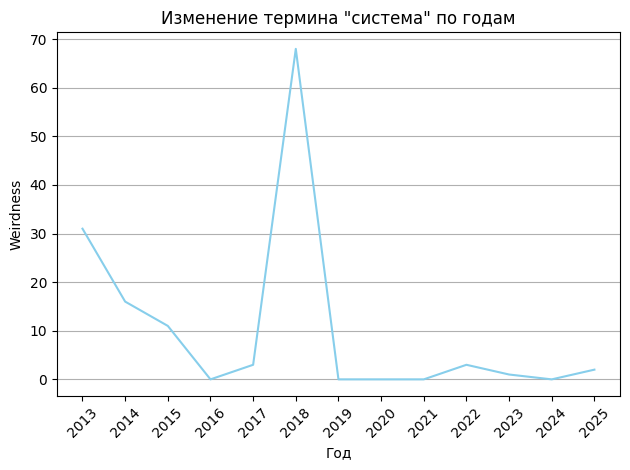

In [156]:
# Создание графика
plt.plot(list(sorted_weirdness_to_year.keys()), list(sorted_weirdness_to_year.values()),
         color='skyblue')

# Настройка заголовка и меток
plt.title(f'Изменение термина "{desired_token}" по годам')
plt.xlabel('Год')
plt.ylabel('Weirdness')

# Отображение графика
plt.xticks(rotation=45)  # Поворот меток по оси X для лучшей читаемости
plt.grid(axis='y')
plt.tight_layout()
plt.show()

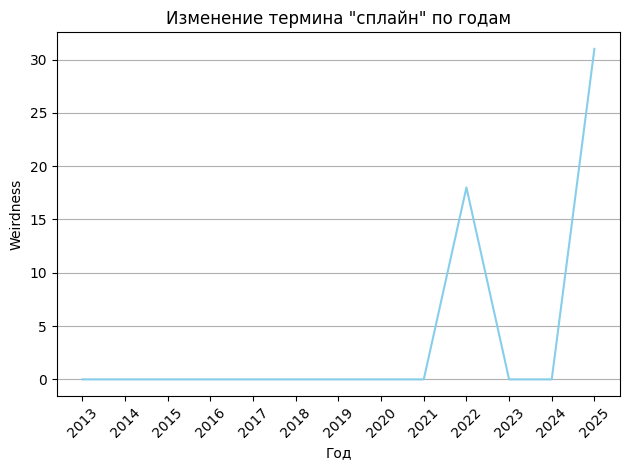

In [166]:
# Создание графика
plt.plot(list(sorted_weirdness_to_year.keys()), list(sorted_weirdness_to_year.values()),
         color='skyblue')

# Настройка заголовка и меток
plt.title(f'Изменение термина "{desired_token}" по годам')
plt.xlabel('Год')
plt.ylabel('Weirdness')

# Отображение графика
plt.xticks(rotation=45)  # Поворот меток по оси X для лучшей читаемости
plt.grid(axis='y')
plt.tight_layout()
plt.show()